In [160]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census
from us import states
import os
import numpy as np
from tabulate import tabulate

In [2]:
# load all files in data folder
files = os.listdir('../data')
files

['algae_pts_with_tracts.csv',
 'data.sqlite',
 'elevation_dem.csv',
 'metadata.csv',
 'sat.csv',
 'spat_lag.csv',
 'split_pred.csv',
 'submission_format.csv',
 'train_labels.csv']

In [3]:
# load all data
train = pd.read_csv('../data/train_labels.csv')
algae_acs = pd.read_csv('../data/algae_pts_with_tracts.csv')
elevation_dem = pd.read_csv('../data/elevation_dem.csv')
metadata = pd.read_csv('../data/metadata.csv')
sat = pd.read_csv('../data/sat.csv')
spat_lag = pd.read_csv('../data/spat_lag.csv')
split_pred = pd.read_csv('../data/split_pred.csv')
submission_fmt = pd.read_csv('../data/submission_format.csv')

### EDA for Training Data
Notes from DrivenData:
* severity (int): severity level based on the cyanobacteria density
* density (float): raw measurement of total cyanobacteria density in cells per mL. Participants should submit predictions for severity level, NOT for the raw cell density value in cells per milliliter (mL). See the Submission format section.

Train columns: ['uid' 'region' 'severity' 'density']


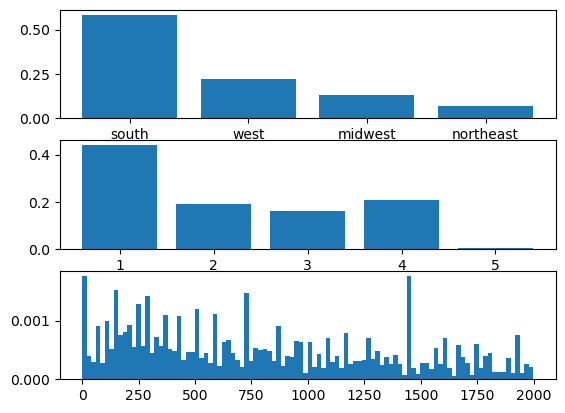

In [41]:
print("Train columns:", train.columns.values)
fig, axs = plt.subplots(3,1)
axs[0].bar(train['region'].value_counts(normalize=True).index,
           train['region'].value_counts(normalize=True))
axs[1].bar(train['severity'].value_counts(normalize=True).index,
            train['severity'].value_counts(normalize=True))
axs[2].hist(train.loc[train['density'] < 2000, 'density'], bins=100, density=True)
plt.show();

In [177]:
train.describe()
train['density'].max()

804667500.0

In [51]:
train.groupby('severity')['density'].agg(['mean', 'median', 'min', 'max'])

,mean,median,min,max
severity,,,,
1,5.261996e+03,3.112000e+03,0.0,19969.0
2,4.864041e+04,4.356800e+04,20000.0,99855.0
3,3.413736e+05,2.561820e+05,100000.0,996254.0
4,4.176759e+06,4.327500e+06,1002767.0,9960000.0
5,4.123169e+07,1.852253e+07,10025000.0,804667500.0


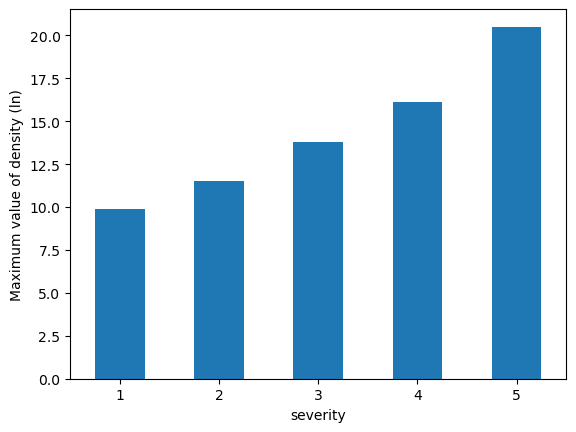

In [171]:
train.groupby('severity')['density'].agg(lambda x: np.log(max(x))).plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Maximum value of density (ln)')
plt.savefig('../plots/max_density_severity.png')
plt.show();

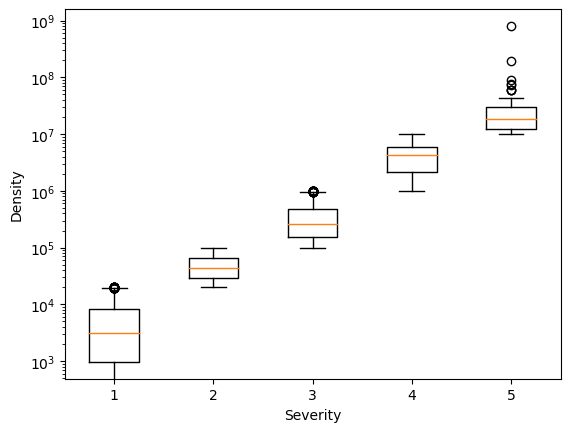

In [190]:
plt.boxplot([train.loc[train['severity']==x,'density'] for x in range(1,6)])
plt.yscale('log')
plt.xticks(rotation=0)
plt.ylabel('Density')
plt.xlabel('Severity')
plt.savefig('../plots/max_density_severity_boxplot.png')
plt.show();

**Important note from DrivenData:** "Each geographic area is either entirely in the train set or entirely in the test set. This means that none of the test set locations are in the training data, so your model's performance will be measured on unseen locations."

What should we consider to be severe?
* From this [article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4014740/#:~:text=In%20particular%2C%20Cyanobacteria%20may%20be,water%20and%20decreases%20its%20transparency): "At times, the phenomenon is so obvious, that the naked eye can see the mass of microscopic algae, which produce blooms giving a particular coloring to the water body. The term “algal blooms” indicates a situation in which 80%–90% of the mass of microscopic algae consists of one or two species. In particular, Cyanobacteria may be considered as blooming when their cell number exceeds one million per liter. This coating of microscopic algae covers the surface of the water and decreases its transparency. This, in turn, prevents the penetration of sunlight, something that, coupled with the thermal stratification typical of reservoirs in the Mediterranean area, inevitably engenders conditions of anoxia and, hence, the above-mentioned consequence"
* Some background from this [article](https://www.nature.com/articles/s41598-019-54453-y): "Cyanobacterial harmful algal blooms (cyanoHABs) are a serious environmental, water quality and public health issue worldwide because of their ability to form dense biomass and scum and to produce toxins such as neurotoxins (anatoxin-a), hepatotoxins (microcystins), and cytotoxins (cylindrospermospin)1. Cyanotoxins are capable of causing a wide variety of adverse human health issues including gastrointestinal distress, dermatitis, liver failure, or even death of domestic and livestock animals when they are exposed to water with toxins from intense cyanoHABs2,3. CyanoHABs are considered to be increasing globally over the past few decades although observations are quite limited4,5. The frequency and magnitude of these blooms are expected to worsen in the future with increased surface water temperatures and vertical stratification6. In addition, cyanoHAB growth and intensity are known to be affected by weather-driven environmental and anthropogenic factors, such as shifts in rainfall patterns with climatology and changing agricultural practices."
    * "Based on the [World Health Organization’s (WHO)](https://www.who.int/publications/m/item/toxic-cyanobacteria-in-water---second-edition) cell abundance threshold, three magnitude classes were considered for categorizing lakes as Low (≤20,000 cells mL−1), Moderate (20,000 ≤ cells mL−1 ≤ 100,000), and High (>100,000 cells mL−1) exposure health risk"

In [78]:
print("severity over 1,000,000:", np.mean(train['density'] > 1000000))
print("severity over 100,000:", np.mean(train['density'] > 100000))
print("severity over 20,000:", np.mean(train['density'] > 20000))

severity over 1,000,000: 0.21131301289566237
severity over 100,000: 0.3705744431418523
severity over 20,000: 0.5604923798358734


In [89]:
train['severity_bin'] = np.where(train['density'] >= 20000, 'high', 'low')
train['severity_bin'].value_counts(normalize=True)

high    0.560551
low     0.439449
Name: severity_bin, dtype: float64

In [90]:
train[['severity_bin','severity']].value_counts(normalize=True)
# based on this I think we categorize high severity severity = 2, 3, 4, or 5

severity_bin  severity
low           1           0.439449
high          4           0.207913
              2           0.189859
              3           0.159379
              5           0.003400
dtype: float64

In [167]:
train[['severity_bin','severity']].value_counts(normalize=True).reset_index().style.to_latex()

'\\begin{tabular}{llrr}\n & severity_bin & severity & 0 \\\\\n0 & low & 1 & 0.439449 \\\\\n1 & high & 4 & 0.207913 \\\\\n2 & high & 2 & 0.189859 \\\\\n3 & high & 3 & 0.159379 \\\\\n4 & high & 5 & 0.003400 \\\\\n\\end{tabular}\n'

In [120]:
mgd_severity_counts = pd.merge(train[['region', 'severity_bin']].value_counts().reset_index(drop=False).sort_values(['region', 'severity_bin']).rename({0:'count'}, axis=1),
         train['region'].value_counts().reset_index(drop=False).rename({'region':'total', 'index':'region'},axis=1),
         on='region')
mgd_severity_counts['pct'] = mgd_severity_counts['count']/mgd_severity_counts['total']
mgd_severity_counts['pct_total'] = mgd_severity_counts['count']/sum(mgd_severity_counts['total'])
mgd_severity_counts

,region,severity_bin,count,total,pct,pct_total
0,midwest,high,1419,2200,0.645000,0.041589
1,midwest,low,781,2200,0.355000,0.022890
2,northeast,high,587,1143,0.513561,0.017204
3,northeast,low,556,1143,0.486439,0.016295
4,south,high,3949,9948,0.396964,0.115739
5,south,low,5999,9948,0.603036,0.175821
6,west,high,3608,3769,0.957283,0.105744
7,west,low,161,3769,0.042717,0.004719


In [121]:
# would we want to evenly sample from each region?

### EDA for Metadata

In [131]:
metadata_train = metadata.loc[metadata['split']=='train']
assert len(metadata['uid'].unique()) == len(metadata['uid'])
assert len(train['uid'].unique()) == len(train['uid'])
assert len(train['uid']) == len(metadata_train['uid'])

In [202]:
metadata_train.dtypes

uid                  object
latitude            float64
longitude           float64
date                 object
split                object
date_fmt     datetime64[ns]
dtype: object

In [205]:
for col in metadata_train.columns.values:
    if len(metadata_train[col].unique()) <= 10:
        print(metadata_train[col].value_counts())

train    17060
Name: split, dtype: int64


C:\Users\Jennah\AppData\Local\Temp\ipykernel_3184\1191734935.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_train['date_fmt'] = pd.to_datetime(metadata_train['date'])
C:\Users\Jennah\AppData\Local\Temp\ipykernel_3184\1191734935.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  metadata_train['date_fmt'].dt.week.value_counts().sort_index().plot(


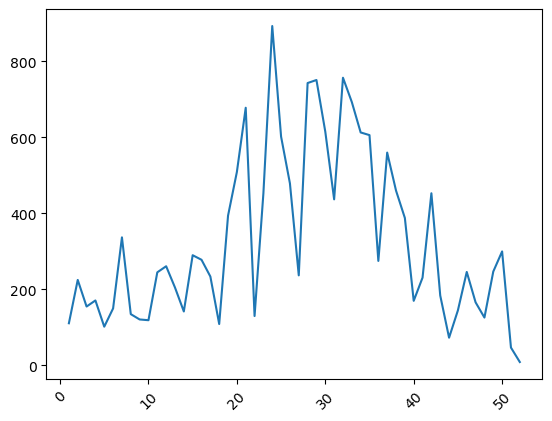

In [147]:
#metadata_train['date'].plot()
metadata_train['date_fmt'] = pd.to_datetime(metadata_train['date'])
metadata_train['date_fmt'].dt.week.value_counts().sort_index().plot(
    rot=45
)
plt.show();

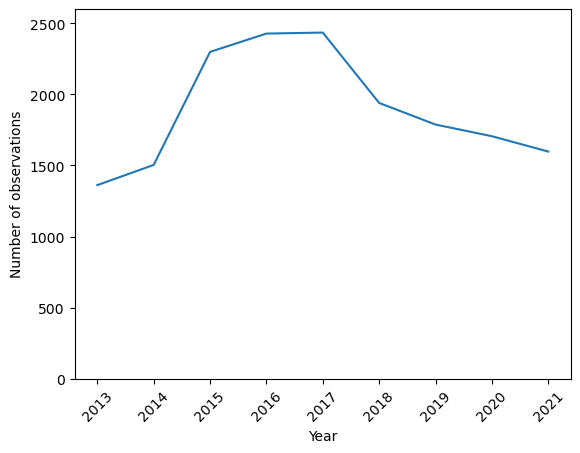

In [198]:
metadata_train['date_fmt'].dt.year.value_counts().sort_index().plot(
    rot=45
)
plt.ylim(0,2600)
plt.ylabel('Number of observations')
plt.xlabel('Year')
plt.savefig('../plots/timeseries_year.png')
plt.show();

We could also do a time-based sampling? For example, sample from more recent years.

### EDA for submission

In [156]:
assert submission_fmt.shape[0] == metadata.loc[metadata['split']=='test'].shape[0]
submission_fmt

,uid,region,severity
0,aabn,west,1
1,aair,west,1
2,aajw,northeast,1
3,aalr,midwest,1
4,aalw,west,1
...,...,...,...
6505,zzpn,northeast,1
6506,zzrv,west,1
6507,zzsx,south,1
6508,zzvv,west,1


In [157]:
submission_fmt['severity'].unique()

array([1], dtype=int64)

In [158]:
submission_fmt['region'].value_counts(normalize=True)

west         0.366667
midwest      0.240399
south        0.232104
northeast    0.160829
Name: region, dtype: float64

### EDA for elevation

In [200]:
elevation_dem

,latitude,longitude,box,elevation,mine,maxe,dife,avge,stde,uid,DateTime
0,35.980000,-78.840901,1000,101.566254,87.542809,130.299011,42.756203,107.346771,8.125100,fvyy,2022-12-22 14:33:31.710640+00:00
1,37.660000,-120.875000,1000,33.648495,26.232449,47.663738,21.431290,38.601562,3.300400,xvyt,2022-12-22 14:33:31.710640+00:00
2,36.130000,-79.067917,1000,187.980103,159.908417,225.662064,65.753647,196.376556,9.686280,gfrm,2022-12-22 14:33:31.710640+00:00
3,35.742000,-79.224930,1000,140.991028,127.858162,191.056915,63.198753,155.453690,10.969849,zmbr,2022-12-22 14:33:31.710640+00:00
4,35.790000,-79.031929,1000,107.646332,62.625713,146.481781,83.856064,94.722862,25.895313,bpvi,2022-12-22 14:33:31.710640+00:00
...,...,...,...,...,...,...,...,...,...,...,...
23565,39.792190,-99.971050,1000,697.500000,697.500000,732.066223,34.566223,702.116211,5.649322,zzwo,2022-12-22 14:33:31.710640+00:00
23566,35.794000,-79.012551,1000,64.000000,64.000000,104.038414,40.038414,67.490509,7.727036,zzwq,2022-12-22 14:33:31.710640+00:00
23567,35.742000,-79.238600,1000,164.907166,133.443787,191.056915,57.613129,160.309174,8.871887,zzyb,2022-12-22 14:33:31.710640+00:00
23568,39.767323,-96.028617,1000,350.000000,345.187805,388.496033,43.308228,363.472412,9.798910,zzzi,2022-12-22 14:33:31.710640+00:00


In [207]:
for col in elevation_dem.columns:
    if len(elevation_dem[col].unique()) <= 10:
        print(elevation_dem[col].value_counts())

1000    23570
Name: box, dtype: int64
2022-12-22 14:33:31.710640+00:00    23570
Name: DateTime, dtype: int64


In [206]:
elevation_dem.dtypes

latitude     float64
longitude    float64
box            int64
elevation    float64
mine         float64
maxe         float64
dife         float64
avge         float64
stde         float64
uid           object
DateTime      object
dtype: object